In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str # 사용자 질문
    answer: str # 세율
    tax_base_equation: str # 과세표준 계산 수식 
    tax_deduction: str # 공제액 
    market_ratio: str # 공정시장가액비율
    tax_base: str # 과세표준 계산
    
graph_builder = StateGraph(AgentState)

In [3]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name = 'real_estate_tax',
    persist_directory='./real_estate_tax_collection'
)
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [4]:
query = '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?'

In [5]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate

rag_prompt = hub.pull('rlm/rag-prompt')
llm = ChatOpenAI(model='gpt-4o')
small_llm = ChatOpenAI(model='gpt-4o-mini')

/Users/jasonkang/.pyenv/versions/3.12.2/envs/inflearn-langgraph-lecture/lib/python3.12/site-packages/langsmith/client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [6]:

tax_base_retrieval_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

tax_base_equation_prompt = ChatPromptTemplate.from_messages([
    ('system', '사용자의 질문에서 과세표준을 계산하는 방법을 수식으로 나타내주세요. 부연설명 없이 수식만 리턴해주세요'),
    ('human', '{tax_base_equation_information}')
])

tax_base_equation_chain = (
    {'tax_base_equation_information': RunnablePassthrough()}
    | tax_base_equation_prompt
    | llm
    | StrOutputParser()
)

tax_base_chain = {'tax_base_equation_information' : tax_base_retrieval_chain} | tax_base_equation_chain

def get_tax_base_equation(state: AgentState):
    tax_base_equation_question = '주택에 대한 종합부동산세 계산시 과세표준을 계산하는 방법을 수식으로 표현해서 알려주세요'
    tax_base_equation = tax_base_chain.invoke(tax_base_equation_question)
    return {'tax_base_equation': tax_base_equation}

In [7]:

tax_deduction_chain = (
    {'context': retriever, 'question': RunnablePassthrough()} 
    | rag_prompt 
    | llm 
    | StrOutputParser()
)

def get_tax_deduction(state: AgentState):
    tax_deduction_question = '주택에 대한 종합부동산세 계산시 공제금액을 알려주세요'
    tax_deduction = tax_deduction_chain.invoke(tax_deduction_question)
    return {'tax_deduction': tax_deduction}

In [8]:
from langchain_community.tools import TavilySearchResults
from datetime import date

tavily_search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
)

tax_market_ratio_prompt = ChatPromptTemplate.from_messages([
    ('system', f'아래 정보를 기반으로 공정시장 가액비율을 계산해주세요\n\nContext:\n{{context}}'),
    ('human', '{query}')
])

def get_market_ratio(state: AgentState):
    query = f'오늘 날짜:({date.today()})에 해당하는 주택 공시가격 공정시장가액비율은 몇%인가요?'
    context = tavily_search_tool.invoke(query)
    print(f'context == {context}')
    tax_market_ratio_chain = (
        tax_market_ratio_prompt
        | llm
        | StrOutputParser()
    )
    market_ratio = tax_market_ratio_chain.invoke({'context': context, 'query': query})
    return {'market_ratio': market_ratio}

In [9]:
from langchain_core.prompts import PromptTemplate

tax_base_calculation_prompt = ChatPromptTemplate.from_messages(
    [
        ('system',"""
주어진 내용을 기반으로 과세표준을 계산해주세요

과세표준 계산 공식: {tax_base_equation}
공제금액: {tax_deduction}
공정시장가액비율: {market_ratio}"""),
        ('human', '사용자 주택 공시가격 정보: {query}')
    ]
)

def calculate_tax_base(state:AgentState):
    tax_base_equation = state['tax_base_equation']
    tax_deduction = state['tax_deduction']
    market_ratio = state['market_ratio']
    query = state['query']
    tax_base_calculation_chain = (
        tax_base_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_base = tax_base_calculation_chain.invoke({
        'tax_base_equation': tax_base_equation,
        'tax_deduction': tax_deduction,
        'market_ratio': market_ratio,
        'query': query
    })
    print(f'tax_base == {tax_base}')
    return {'tax_base': tax_base}

In [10]:
initial_state = {
    'query': query,
    'tax_base_equation': '과세표준 = (주택 공시가격 합산 - 공제금액) × 공정시장가액비율',
    'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원, 법인 또는 법인으로 보는 단체의 경우 6억 원, 그 외의 경우에는 9억 원입니다.',
    'market_ratio': '2024년 주택 공시가격의 공정시장가액비율은 60%입니다.'
}


In [14]:
tax_rate_calculation_prompt = ChatPromptTemplate.from_messages([
    ('system', '''당신은 종합부동산세 계산 전문가입니다. 아래 문서를 참고해서 사용자의 질문에 대한 종합부동산세를 계산해주세요

종합부동산세 세율:{context}'''),
    ('human', '''과세표준과 사용자가 소지한 주택의 수가 아래와 같을 때 종합부동산세를 계산해주세요

과세표준: {tax_base}
주택 수:{query}''')
])

def calculate_tax_rate(state: AgentState):
    query = state['query']
    tax_base = state['tax_base']
    context = retriever.invoke(query)
    tax_rate_chain = (
        tax_rate_calculation_prompt
        | llm
        | StrOutputParser()
    )
    tax_rate = tax_rate_chain.invoke({
        'context': context, 
        'tax_base': tax_base, 
        'query': query
    })
    print(f'tax_rate == {tax_rate}')
    return {'answer': tax_rate}

In [12]:
calculate_tax_base(initial_state)

tax_base == 사용자가 보유한 주택의 공시가격 합산은 다음과 같습니다:

5억 원 + 10억 원 + 20억 원 = 35억 원

사용자는 1세대 1주택자가 아니고 법인도 아니므로 공제금액은 9억 원입니다.

과세표준을 계산하면 다음과 같습니다:

과세표준 = (35억 원 - 9억 원) × 60%
과세표준 = 26억 원 × 0.6
과세표준 = 15.6억 원

따라서 사용자의 과세표준은 15.6억 원입니다. 이 과세표준을 기반으로 종합부동산세를 계산할 수 있습니다. 구체적인 세율이 필요하다면 해당 연도의 세율표를 참고하시기 바랍니다.


{'tax_base': '사용자가 보유한 주택의 공시가격 합산은 다음과 같습니다:\n\n5억 원 + 10억 원 + 20억 원 = 35억 원\n\n사용자는 1세대 1주택자가 아니고 법인도 아니므로 공제금액은 9억 원입니다.\n\n과세표준을 계산하면 다음과 같습니다:\n\n과세표준 = (35억 원 - 9억 원) × 60%\n과세표준 = 26억 원 × 0.6\n과세표준 = 15.6억 원\n\n따라서 사용자의 과세표준은 15.6억 원입니다. 이 과세표준을 기반으로 종합부동산세를 계산할 수 있습니다. 구체적인 세율이 필요하다면 해당 연도의 세율표를 참고하시기 바랍니다.'}

In [13]:
tax_base_state = {'tax_base': '사용자가 보유한 주택의 공시가격 합산은 다음과 같습니다:\n\n5억 원 + 10억 원 + 20억 원 = 35억 원\n\n사용자는 1세대 1주택자가 아니고 법인도 아니므로 공제금액은 9억 원입니다.\n\n과세표준을 계산하면 다음과 같습니다:\n\n과세표준 = (35억 원 - 9억 원) × 60%\n과세표준 = 26억 원 × 0.6\n과세표준 = 15.6억 원\n\n따라서 사용자의 과세표준은 15.6억 원입니다. 이 과세표준을 기반으로 종합부동산세를 계산할 수 있습니다. 구체적인 세율이 필요하다면 해당 연도의 세율표를 참고하시기 바랍니다.', 'query': query}

In [15]:
calculate_tax_rate(tax_base_state)

tax_rate == 사용자는 총 3채의 주택을 소유하고 있으므로, 3주택 이상의 세율을 적용해야 합니다. 과세표준이 15.6억 원이므로, 아래 세율표를 참조하여 계산할 수 있습니다.

3주택 이상 소유자의 경우, 과세표준 12억 원 초과 25억 원 이하 구간에 해당합니다. 해당 구간의 세율은 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)입니다.

1. 과세표준이 15.6억 원이므로, 12억 원을 초과하는 금액은:
   15.6억 원 - 12억 원 = 3.6억 원

2. 초과 금액에 대한 세액은:
   3.6억 원 × 0.002 (1천분의 20) = 720만 원

3. 기본 세액에 초과분 세액을 더하면:
   960만 원 + 720만 원 = 1,680만 원

따라서 사용자는 종합부동산세로 1,680만 원을 납부해야 합니다.


{'answer': '사용자는 총 3채의 주택을 소유하고 있으므로, 3주택 이상의 세율을 적용해야 합니다. 과세표준이 15.6억 원이므로, 아래 세율표를 참조하여 계산할 수 있습니다.\n\n3주택 이상 소유자의 경우, 과세표준 12억 원 초과 25억 원 이하 구간에 해당합니다. 해당 구간의 세율은 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)입니다.\n\n1. 과세표준이 15.6억 원이므로, 12억 원을 초과하는 금액은:\n   15.6억 원 - 12억 원 = 3.6억 원\n\n2. 초과 금액에 대한 세액은:\n   3.6억 원 × 0.002 (1천분의 20) = 720만 원\n\n3. 기본 세액에 초과분 세액을 더하면:\n   960만 원 + 720만 원 = 1,680만 원\n\n따라서 사용자는 종합부동산세로 1,680만 원을 납부해야 합니다.'}

In [16]:
graph_builder.add_node('get_tax_base_equation', get_tax_base_equation)
graph_builder.add_node('get_tax_deduction', get_tax_deduction)
graph_builder.add_node('get_market_ratio', get_market_ratio)
graph_builder.add_node('calculate_tax_base', calculate_tax_base)
graph_builder.add_node('calculate_tax_rate', calculate_tax_rate)

In [17]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'get_tax_base_equation')
graph_builder.add_edge(START, 'get_tax_deduction')
graph_builder.add_edge(START, 'get_market_ratio')
graph_builder.add_edge('get_tax_base_equation', 'calculate_tax_base')
graph_builder.add_edge('get_tax_deduction', 'calculate_tax_base')
graph_builder.add_edge('get_market_ratio', 'calculate_tax_base')
graph_builder.add_edge('calculate_tax_base', 'calculate_tax_rate')
graph_builder.add_edge('calculate_tax_rate', END)

In [18]:
graph = graph_builder.compile()

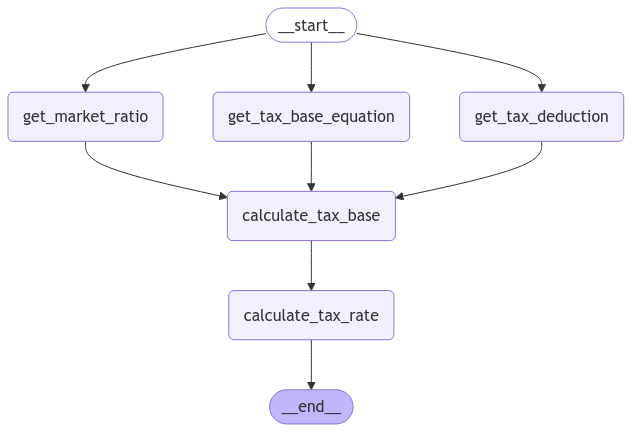

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
initial_state = {'query': query}
graph.invoke(initial_state)

context == [{'url': 'https://m.blog.naver.com/bigtiger001/223338181578', 'content': '2024년 표준주택 공시가격 ... 종부세 과세기준 즉 공제금액은 주택 9억원, 1주택자 12억원 등 아래와 같습니다. ... 공정시장가액비율은 지방세법 시행령에서 주택 60%, 토지와 건축물은 70%로 정하고 있습니다. 따라서 공시가격 인하는 재산세의 과세표준 인하와'}, {'url': 'https://superheroeddy.com/entry/공동주택공시가격-상승으로-2024-재산세-인상-공정시장가액비율은-유지', 'content': '공동주택공시가격 = 재산세과표 / 공정시장가액비율. 내 경우 재산세과표는 391,747,500원(서울시 재산세 납부 고지서를 보면 나와있다 ㅋ). 공정시장가액비율은 24년에도 변함없이 45%, 즉 0.45다.'}, {'url': 'https://www.newsis.com/view/NISX20231219_0002563941', 'content': "국토부 '2024 표준지·표준주택 공시가격' 공시 올해와 동일하게 2020년 수준 현실화율 적용 서울 1.17% 경기 1.05% 세종 0.91% 순 표준지 공시가격은 1.1%"}, {'url': 'https://m.blog.naver.com/bigtiger001/223416545346', 'content': '2024년 재산세 과표, 세율 종합정리 (공정시장가액비율, 토지, 1주택자 특례, 납세기준일 7월과 9월) : 네이버 블로그 2024년 재산세 과표, 세율 종합정리 (공정시장가액비율, 토지, 1주택자 특례, 납세기준일 7월과 9월) 이에 2024년 재산세 과표, 세율 등을 정리해 보는 포스팅입니다. 1. 재산세 개요\u200b 2. 재산세 산출식 3. 재산세 시가표준액(공시가격) 4. 재산세 공정시장가액비율 즉 재산세 과표가 3억이하시 43%, 6억이하시 44%, 6억초과시 45%가 적용되었습니다. 5. 재산세 세율 재산세 세율

{'query': '5억짜리 집 1채, 10억짜리 집 1채, 20억짜리 집 1채를 가지고 있을 때 세금을 얼마나 내나요?',
 'answer': '과세표준이 15.6억 원이고, 사용자가 3주택 이상 소유한 경우에 해당됩니다. 따라서 3주택 이상의 소유자에 대한 세율을 사용해야 합니다. \n\n과세표준 15.6억 원에 대한 3주택 이상 소유자의 세율은 다음과 같습니다:\n\n- 12억 원 초과 25억 원 이하: 960만 원 + (12억 원을 초과하는 금액의 1천분의 20)\n\n즉, 과세표준 15.6억 원에 대한 종합부동산세는:\n\n1. 12억 원을 초과하는 금액: 15.6억 원 - 12억 원 = 3.6억 원\n2. 3.6억 원의 1천분의 20: 3.6억 원 × 0.002 = 720만 원\n3. 기본 세액: 960만 원\n\n최종 종합부동산세 = 기본 세액 + 초과 금액에 대한 세액 = 960만 원 + 720만 원 = 1,680만 원\n\n따라서, 사용자는 1,680만 원의 종합부동산세를 납부해야 합니다.',
 'tax_base_equation': '과세표준 = (공시가격 합계 - 공제액) × 공정시장가액비율',
 'tax_deduction': '주택에 대한 종합부동산세 계산 시 공제금액은 1세대 1주택자의 경우 12억 원, 법인 또는 법인으로 보는 단체는 6억 원, 그 외의 경우는 9억 원입니다.',
 'market_ratio': '2024년 주택 공시가격의 공정시장가액비율은 60%입니다.',
 'tax_base': '사용자가 보유한 주택의 공시가격 합계는 다음과 같습니다:\n\n- 5억 원짜리 집 1채\n- 10억 원짜리 집 1채\n- 20억 원짜리 집 1채\n\n공시가격 합계 = 5억 원 + 10억 원 + 20억 원 = 35억 원\n\n사용자가 1세대 1주택자가 아니라면 공제금액은 9억 원입니다.\n\n따라서 과세표준은 다음과 같이 계산됩니다:\n\n과세표준 = (공시가격 합계 - 공제액) × 공정시장가액비율\n과세표준 = (35억 원 - 9억 원) × 